### Project Title :- House Price Prediction

### Dataset Information

I collected this dataset from Kaggle. It contains 13,320 records of housing data with 9 key features, including area type, availability, location, size (e.g., number of bedrooms), society name, total square feet, number of bathrooms and balconies, and the property price in lakhs. This dataset is ideal for real estate analysis and building predictive models to estimate house prices based on various property attributes.

### Problem Statement
The goal of this project is to build a machine learning model that can predict the selling price of a house based on its features. Buying or selling a home involves big financial decisions, and knowing the right price is very important.

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from sklearn.linear_model import Lasso, Ridge , LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
import pickle

In [2]:
# Load Data
df = pd.read_csv('House_Data.csv')

In [3]:
# Check the size of the data
df.shape

(13320, 9)

In [4]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,NaN,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,NaN,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  6305 non-null   object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [6]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


### Data Cleaning

In [7]:
df.isna().sum()

area_type          0
availability    7015
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

In [8]:
# Drop irrelevant or mostly empty columns
df.drop(['availability', 'society'], axis=1, inplace=True)

In [9]:
# Drop missing values from crucial columns
df.dropna(subset=['area_type','total_sqft', 'price', 'bath','balcony','size', 'location'], inplace=True)

In [10]:
df['total_sqft'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(1976,), dtype=object)

In [11]:
# Clean total_sqft column
def clean_total_sqft(x):
    try:
        x = x.strip()
        if '-' in x:
            tokens = x.split('-')
            return (float(tokens[0]) + float(tokens[1])) / 2
        
        return None
    except:
        return None

In [12]:
df['total_sqft'] = df['total_sqft'].astype(str).apply(clean_total_sqft)
df.dropna(subset=['total_sqft'], inplace=True)

### Feature Engineering

In [13]:
# Create new features
df['bhk'] = df['size'].apply(lambda x: int(str(x).split(' ')[0]))
df.drop('size', axis=1, inplace=True)

In [14]:
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']

### Data Encoding

In [15]:
# Encode area_type
df = pd.get_dummies(df, columns=['area_type'], drop_first=True)

In [16]:
# Clean and encode location
df['location'] = df['location'].apply(lambda x: str(x).strip())
location_stats = df['location'].value_counts()
location_stats_less_than_10 = location_stats[location_stats <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
df = pd.get_dummies(df, columns=['location'], drop_first=True)

### Outlier Removing

<Axes: xlabel='price'>

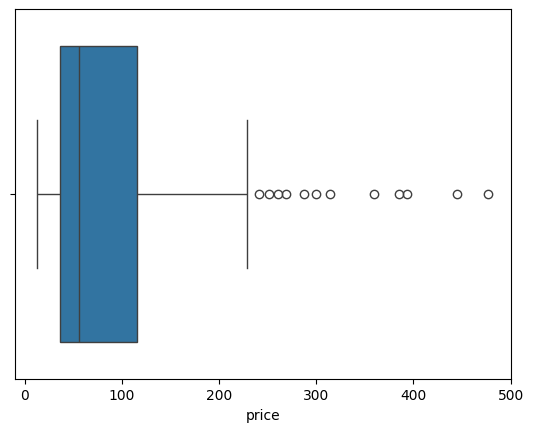

In [17]:
sns.boxplot( data= df , x= 'price')

<Axes: xlabel='price_per_sqft'>

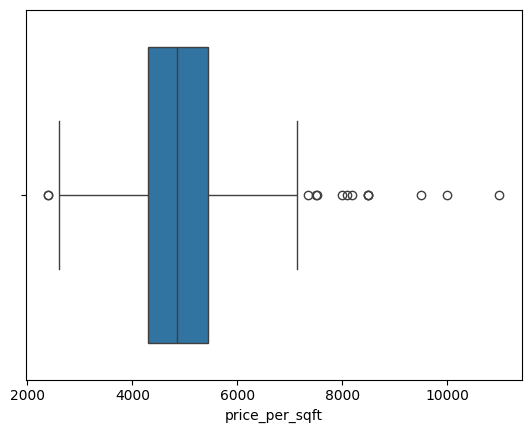

In [18]:
sns.boxplot( data= df , x= 'price_per_sqft')

In [19]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]


In [20]:
df = remove_outliers_iqr(df, 'price_per_sqft')

In [21]:
df = remove_outliers_iqr(df, 'price')

### Define Features and Target

In [22]:
# Define features and target
X = df.drop(['price', 'price_per_sqft'], axis=1)
y = df['price']

### Data Scaling

In [23]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Data Splitting

In [24]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=72)

### Model Evaluation

In [25]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Support Vector Regression": SVR(),
    "Decision Tree Regression": DecisionTreeRegressor(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    "XGBoost Regression": xgb.XGBRegressor(),
    "KNN Regression": KNeighborsRegressor(),
}


In [26]:
# Loop through models and evaluate
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)

    # Testing metrics
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)

    # Print metrics
    print(f"Train MAE:  {train_mae:.2f}")
    print(f"Test MAE:   {test_mae:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test RMSE:  {test_rmse:.2f}")
    print(f"Train R2:   {train_r2:.2f}")
    print(f"Test R2:    {test_r2:.2f}")


Linear Regression
Train MAE:  7.26
Test MAE:   6.72
Train RMSE: 9.37
Test RMSE:  9.28
Train R2:   0.93
Test R2:    0.93

Ridge Regression
Train MAE:  7.37
Test MAE:   6.84
Train RMSE: 9.51
Test RMSE:  9.33
Train R2:   0.93
Test R2:    0.93

Lasso Regression
Train MAE:  7.88
Test MAE:   7.03
Train RMSE: 10.14
Test RMSE:  10.17
Train R2:   0.92
Test R2:    0.91

Support Vector Regression
Train MAE:  20.74
Test MAE:   22.57
Train RMSE: 33.29
Test RMSE:  33.19
Train R2:   0.16
Test R2:    0.06

Decision Tree Regression
Train MAE:  0.70
Test MAE:   6.96
Train RMSE: 2.66
Test RMSE:  9.45
Train R2:   0.99
Test R2:    0.92

Random Forest Regression
Train MAE:  3.16
Test MAE:   6.98
Train RMSE: 4.36
Test RMSE:  9.34
Train R2:   0.99
Test R2:    0.93

Gradient Boosting Regression
Train MAE:  2.87
Test MAE:   7.02
Train RMSE: 4.00
Test RMSE:  9.50
Train R2:   0.99
Test R2:    0.92

XGBoost Regression
Train MAE:  0.76
Test MAE:   8.07
Train RMSE: 2.66
Test RMSE:  10.79
Train R2:   0.99
Test R2:  

### 1. Random Forest 

In [27]:
# Train Random Forest
model = RandomForestRegressor(n_estimators=100 , min_samples_split= 4 ,min_samples_leaf= 4 ,random_state=72)
model.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,4
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [28]:
# Predict on training set
y_train_pred = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Predict on testing set]
y_test_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print evaluation metrics
print("\nRandom Forest Model Evaluation:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R^2 Score: {train_r2:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")


Random Forest Model Evaluation:
Train RMSE: 7.70
Test RMSE: 9.81
Train MAE: 6.05
Test MAE: 7.35
Train R^2 Score: 0.9553
Test R^2 Score: 0.9177


### 2. Lasso Model

In [29]:
l_model = Lasso()
l_model.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [30]:
# Predict on training set
y_train_pred = l_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Predict on testing set
y_test_pred = l_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print evaluation metrics
print("\nLasso Model Evaluation:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R^2 Score: {train_r2:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")


Lasso Model Evaluation:
Train RMSE: 10.14
Test RMSE: 10.17
Train MAE: 7.88
Test MAE: 7.03
Train R^2 Score: 0.9224
Test R^2 Score: 0.9115


### 3. Ridge Model

In [31]:
r_model = Ridge(alpha=1.0)
r_model.fit(X_train, y_train)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [32]:
# Predict on training set
y_train_pred = r_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Predict on testing set
y_test_pred = r_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Print evaluation metrics
print("\nRidge Model Evaluation:")
print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Train R^2 Score: {train_r2:.4f}")
print(f"Test R^2 Score: {test_r2:.4f}")


Ridge Model Evaluation:
Train RMSE: 9.51
Test RMSE: 9.33
Train MAE: 7.37
Test MAE: 6.84
Train R^2 Score: 0.9317
Test R^2 Score: 0.9255


### Compare the Model

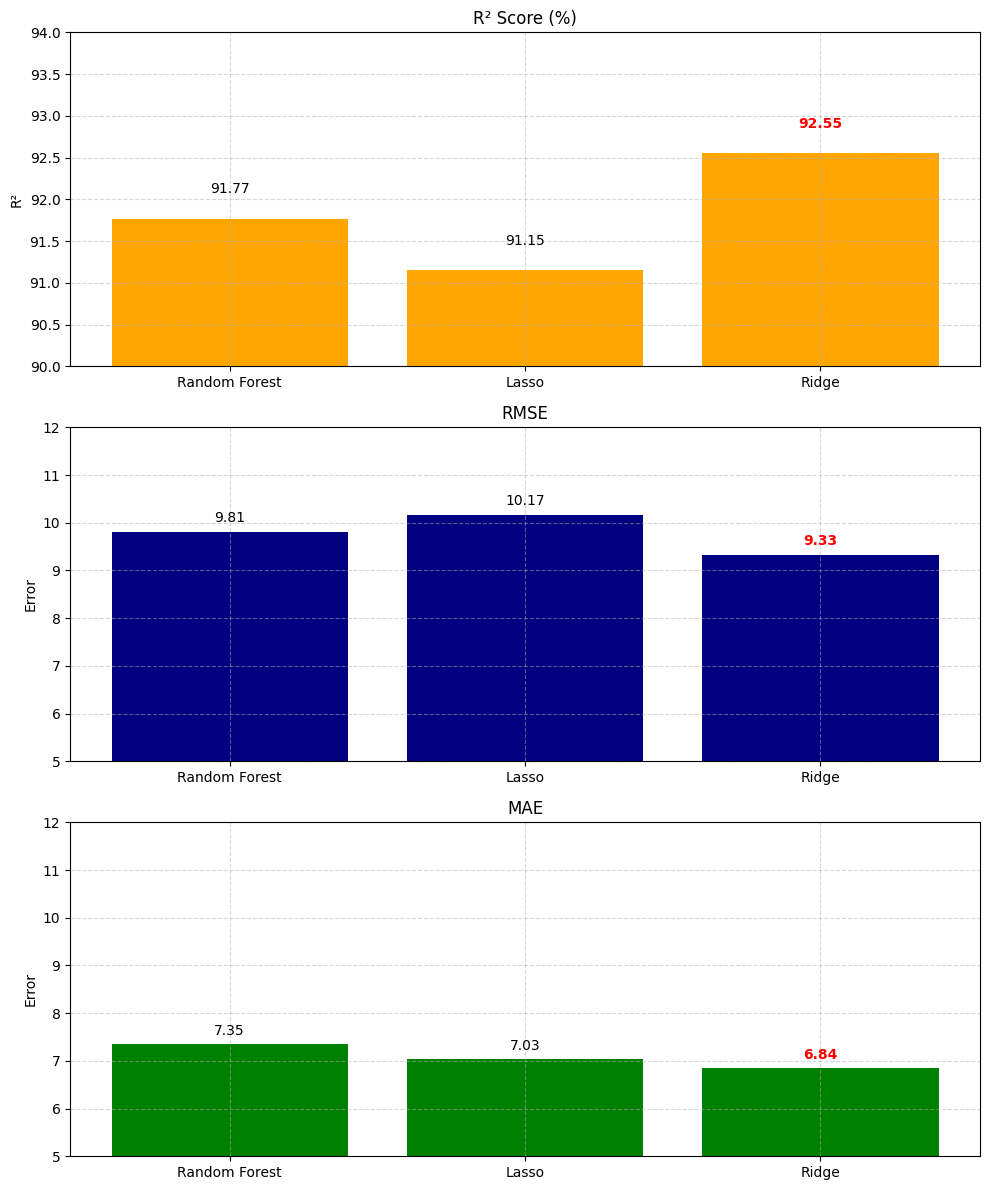

In [36]:
# Model names and metric values
models = ['Random Forest', 'Lasso', 'Ridge']
r2_scores = [91.77, 91.15, 92.55]
rmse_scores = [9.81, 10.17, 9.33]
mae_scores = [7.35, 7.03, 6.84]

x = np.arange(len(models))

# Subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Define y-axis ranges for consistent scale
r2_ylim = (90, 94 )
rmse_ylim = (5, 12)
mae_ylim = (5, 12)

# Index of Ridge model
ridge_idx = models.index("Ridge")

# R² Score subplot
axs[0].bar(models, r2_scores, color='orange')
axs[0].set_title('R² Score (%)')
axs[0].set_ylabel('R²')
axs[0].set_ylim(r2_ylim)
axs[0].grid(True, linestyle='--', alpha=0.5)

for i, val in enumerate(r2_scores):
    color = 'red' if i == ridge_idx else 'black'
    axs[0].text(i, val + 0.3, f"{val:.2f}", ha='center', color=color, fontweight='bold' if i == ridge_idx else 'normal')

# RMSE subplot
axs[1].bar(models, rmse_scores, color='navy')
axs[1].set_title('RMSE')
axs[1].set_ylabel('Error')
axs[1].set_ylim(rmse_ylim)
axs[1].grid(True, linestyle='--', alpha=0.5)

for i, val in enumerate(rmse_scores):
    color = 'red' if i == ridge_idx else 'black'
    axs[1].text(i, val + 0.2, f"{val:.2f}", ha='center', color=color, fontweight='bold' if i == ridge_idx else 'normal')

# MAE subplot
axs[2].bar(models, mae_scores, color='green')
axs[2].set_title('MAE')
axs[2].set_ylabel('Error')
axs[2].set_ylim(mae_ylim)
axs[2].grid(True, linestyle='--', alpha=0.5)

for i, val in enumerate(mae_scores):
    color = 'red' if i == ridge_idx else 'black'
    axs[2].text(i, val + 0.2, f"{val:.2f}", ha='center', color=color, fontweight='bold' if i == ridge_idx else 'normal')

plt.tight_layout()
plt.show()

### Save The Best Model

In [34]:
with open('ridge_model.pkl', 'wb') as f:
    pickle.dump(r_model, f)

### Conclusion
In this project, we successfully built a machine learning model to predict house prices based on important features like location, size, number of bedrooms, bathrooms, and more. After cleaning and preparing the data, we used different regression models such as Random Forest, Lasso, and Ridge to find the best way to predict prices.
Among these, the  Ridge Model performed the best, giving us accurate results on both the training and test datasets.
This model can now be used to:
Help buyers and sellers estimate fair prices,
Assist real estate agents in decision-making,
And support investors in identifying valuable properties.
By using real-world data and machine learning techniques, we made the price prediction process more efficient, accurate, and data-driven.